In [1]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
from plotnine import *

from saged.utils import parse_map_file, split_sample_names

## Set Up Functions and Get Metadata

In [2]:
def return_unlabeled():
    # For use in a defaultdict
    return 'unlabeled'

In [3]:
data_dir = '../../data/simulated'
map_file = os.path.join(data_dir, 'simulation_labels.pkl')

sample_to_label = parse_map_file(map_file)
sample_to_label = collections.defaultdict(return_unlabeled, sample_to_label)

In [4]:
metadata_path = os.path.join(data_dir, 'sample_metadata.json')
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)
sample_metadata = metadata['samples']

In [5]:
experiments = metadata['experiments']
sample_to_study = {}
for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

## Sepsis classification

In [6]:
in_files = glob.glob('../../results/simulation.sepsis*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/simulation.sepsis.pytorch_supervised.0.tsv', '../../results/simulation.sepsis.pytorch_supervised.2.tsv', '../../results/simulation.sepsis.logistic_regression.0.tsv', '../../results/simulation.sepsis.deep_net.2.tsv', '../../results/simulation.sepsis.logistic_regression.1.tsv']


In [7]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,0.5375,0.500000,0.000000,"Experiment_sepsis_healthy_19,Experiment_sepsis...","sepsis_healthy_650,sepsis_healthy_475,sepsis_h...","sepsis_0,sepsis_3,sepsis_7,sepsis_9,sepsis_10,...",146,0.1,three_layer_net,pytorch_supervised,146
1,0.5375,0.500000,0.000000,"Experiment_sepsis_21,Experiment_sepsis_healthy...","sepsis_healthy_650,sepsis_healthy_475,sepsis_h...","sepsis_0,sepsis_3,sepsis_7,sepsis_9,sepsis_10,...",292,0.2,three_layer_net,pytorch_supervised,292
2,0.7675,0.748649,0.664260,"Experiment_sepsis_healthy_19,Experiment_sepsis...","sepsis_healthy_650,sepsis_healthy_475,sepsis_h...","sepsis_0,sepsis_3,sepsis_7,sepsis_9,sepsis_10,...",438,0.3,three_layer_net,pytorch_supervised,438
3,0.9850,0.984915,0.983784,"Experiment_sepsis_healthy_19,Experiment_sepsis...","sepsis_healthy_650,sepsis_healthy_475,sepsis_h...","sepsis_0,sepsis_3,sepsis_7,sepsis_9,sepsis_10,...",584,0.4,three_layer_net,pytorch_supervised,584
4,0.9750,0.972973,0.972222,"Experiment_sepsis_healthy_19,Experiment_sepsis...","sepsis_healthy_650,sepsis_healthy_475,sepsis_h...","sepsis_0,sepsis_3,sepsis_7,sepsis_9,sepsis_10,...",730,0.5,three_layer_net,pytorch_supervised,730
...,...,...,...,...,...,...,...,...,...,...,...
45,0.5300,0.500000,0.000000,"Experiment_sepsis_898,Experiment_sepsis_648,Ex...","sepsis_healthy_993,sepsis_healthy_937,sepsis_h...","sepsis_0,sepsis_4,sepsis_9,sepsis_10,sepsis_11...",891,0.6,three_layer_net,pytorch_supervised,891
46,0.5300,0.500000,0.000000,"Experiment_sepsis_898,Experiment_sepsis_648,Ex...","sepsis_healthy_993,sepsis_healthy_937,sepsis_h...","sepsis_0,sepsis_4,sepsis_9,sepsis_10,sepsis_11...",1040,0.7,three_layer_net,pytorch_supervised,1040
47,0.5300,0.500000,0.000000,"Experiment_sepsis_898,Experiment_sepsis_648,Ex...","sepsis_healthy_993,sepsis_healthy_937,sepsis_h...","sepsis_0,sepsis_4,sepsis_9,sepsis_10,sepsis_11...",1188,0.8,three_layer_net,pytorch_supervised,1188
48,0.5300,0.500000,0.000000,"Experiment_sepsis_healthy_186,Experiment_sepsi...","sepsis_healthy_993,sepsis_healthy_937,sepsis_h...","sepsis_0,sepsis_4,sepsis_9,sepsis_10,sepsis_11...",1337,0.9,three_layer_net,pytorch_supervised,1337


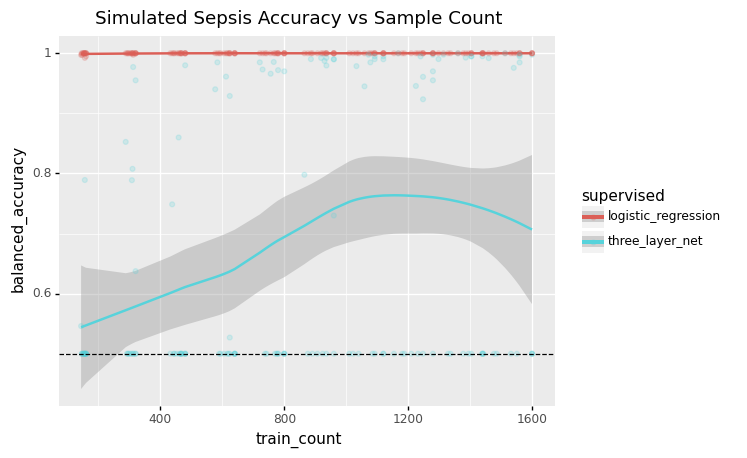

<ggplot: (8733008535785)>

In [8]:
plot = ggplot(sepsis_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count')
plot

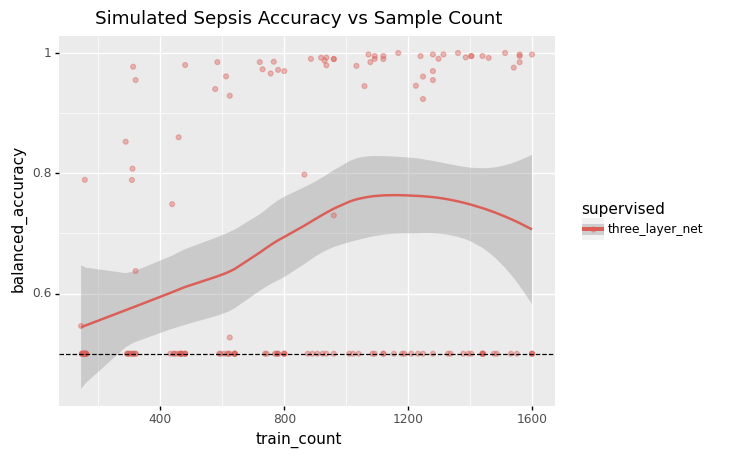

<ggplot: (8733009797905)>

In [9]:
plot = ggplot(sepsis_metrics[sepsis_metrics['supervised'] == 'three_layer_net'], aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.4)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count')
plot

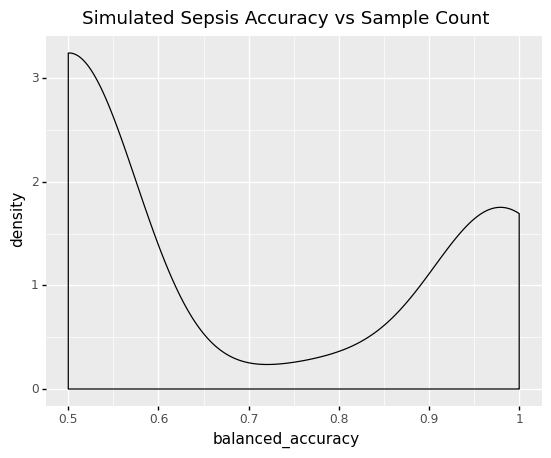

<ggplot: (8733008536625)>

In [10]:
plot = ggplot(sepsis_metrics[sepsis_metrics['supervised'] == 'three_layer_net'], aes(x='balanced_accuracy')) 
plot += geom_density()
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count')
plot